## Import Libs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from time import strftime

from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D
from tensorflow import keras
import time

import stat
import os
import time
from time import sleep
import sys
import smtplib
from datetime import datetime

%matplotlib inline

Using TensorFlow backend.


# Config

In [2]:
gmail_user = 'X'
gmail_pwd = 'X'
recipients = 'X'

In [3]:
def send_email():
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(gmail_user, gmail_pwd)

    now = datetime.now()
    Text = "DONE RUNNING"
    message = 'Subject: {}\n\n{}'.format((str(Text) + "="+now.strftime("%d/%m/%Y %H:%M:%S")), Text)
    server.sendmail(gmail_user, recipients, message)
    server.quit()

# Build Model

In [4]:
model = Sequential([Flatten(input_shape=(96,96)),
                         Dense(128, activation="relu"),
                         Dropout(0.1),
                         Dense(64, activation="relu"),
                         Dense(30)
                         ])

In [5]:
model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))

## Show The Model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)       

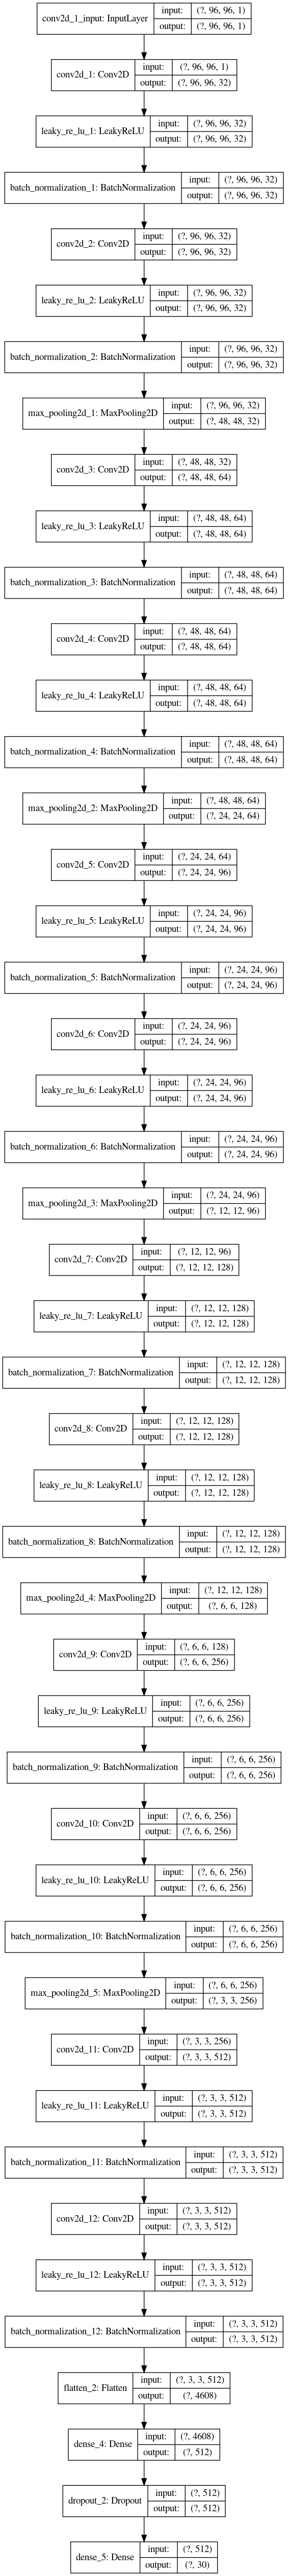

In [6]:
model.summary()
keras.utils.plot_model(model, show_shapes=True)

## Compile The Model

In [7]:
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mae','accuracy'])

# Load Augmented Images

In [12]:
train_data_aug = pd.read_csv('train_aug.csv')

## Possible Augmentations To Pick From

In [13]:
print(train_data_aug.aug.unique())

['rotation_15' 'rotation_25' 'rotation_20' 'rotation_10' 'rotation_-20'
 'rotation_-10' 'rotation_-5' 'rotation_5' 'mirror' 'pixel.5.5'
 'pixel.4.4' 'pixel.3.3' 'shift_5_-10' 'shift_=5_-5' 'shift_5_5'
 'shift_-3_-3' 'shift_5_0' 'zoom_1.8_1.8' 'zoom_1.5_1.5' 'zoom_1.2_1.3'
 'zoom_1_.95' 'zoom_0.95_.95']


## Selecting the Desired Image Augmentation

In [14]:
train_data_aug = train_data_aug[train_data_aug['aug'] != 'pixel.5.5']
train_data_aug = train_data_aug[train_data_aug['aug'] != 'pixel.4.4']
train_data_aug = train_data_aug[train_data_aug['aug'] != 'pixel.3.3']
train_data_aug = train_data_aug[train_data_aug['aug'] != 'pixel.5.5']
train_data_aug = train_data_aug[train_data_aug['aug'] != 'zoom_1.5_1.5']
train_data_aug = train_data_aug[train_data_aug['aug'] != 'rotation_15']
train_data_aug = train_data_aug[train_data_aug['aug'] != 'rotation_25']
train_data_aug = train_data_aug[train_data_aug['aug'] != 'rotation_20']
train_data_aug = train_data_aug[train_data_aug['aug'] != 'rotation_10']
train_data_aug = train_data_aug[train_data_aug['aug'] != 'rotation_-20']
train_data_aug = train_data_aug[train_data_aug['aug'] != 'shift_5_-10']
train_data_aug = train_data_aug[train_data_aug['aug'] != 'zoom_1_.95']
train_data_aug = train_data_aug[train_data_aug['aug'] != 'zoom_0.95_.95']
train_data_aug = train_data_aug[train_data_aug['aug'] != 'shift_5_-10']
train_data_aug = train_data_aug[train_data_aug['aug'] != 'zoom_1.8_1.8']
train_data_aug = train_data_aug[train_data_aug['aug'] != 'zoom_1.2_1.3']
train_data_aug = train_data_aug[train_data_aug['aug'] != 'shift_5_0']
train_data_aug = train_data_aug[train_data_aug['aug'] != 'shift_-3_-3']
train_data_aug = train_data_aug[train_data_aug['aug'] != 'shift_=5_-5']
train_data_aug = train_data_aug[train_data_aug['aug'] != 'shift_5_5']
train_data_aug = train_data_aug[train_data_aug['aug'] != 'rotation_-10']
#train_data_aug = train_data_aug[train_data_aug['aug'] != 'rotation_5']
#train_data_aug = train_data_aug[train_data_aug['aug'] != 'rotation_-5']

print(train_data_aug.aug.unique())
train_data_aug.drop(columns=['aug','unique_id'],inplace=True,axis=0)

['rotation_-5' 'rotation_5' 'mirror']


## Only Select Sample From Augmented Images

In [15]:
train_data_aug = train_data_aug.sample(frac=0.1)
print(len(train_data_aug))

630


## Load The Training Set & Add Processed Image Flags

In [16]:
train_data = pd.read_csv('training.csv')
train_data_ext = pd.read_csv('processed_training_flag.csv')
train_data = pd.merge(train_data,train_data_ext,left_index=True, right_index=True)

## Filter Based on Desired Flags from Processed Images

In [17]:
train_data =  train_data[train_data['is_extreme_image'] == 0]
#train_data =  train_data[train_data['is_missing_pixel'] == 0]
#train_data =  train_data[train_data['num_missing_keypoints'] == 0]
#train_data =  train_data[train_data['is_duplicate'] == 0]
train_data.drop(columns=['is_extreme_image','is_missing_pixel','num_missing_keypoints','Unnamed: 0','is_duplicate'],inplace=True,axis=0)

# Merge with train_data

In [18]:
train_data = pd.concat([train_data,train_data_aug])

# Fill Missing Features with Average

In [19]:
train_data = train_data.reset_index(drop=True)
train_data = train_data.fillna(method = 'ffill')

## Load Training Set into Numpy Array for Model

In [20]:
images = []
y_train = []

for idx, sample in train_data.iterrows():
    image = np.array(sample['Image'].split(' '), dtype=int)
    image = np.reshape(image, (96,96,1))
    images.append(image)
X_train = np.array(images)

training = train_data.drop('Image',axis = 1)

y_train = []
print(len(training))
for idx,sample in training.iterrows():
    y = training.iloc[idx,:]
    y_train.append(y)    
y_train = np.array(y_train,dtype = 'float')

7656


# Run Model

In [21]:
#start the timer
start_time = time.time()  

#Run Model
result = model.fit(X_train,y_train,epochs = 300,batch_size = 800,validation_split = 0.05,verbose=1)

#end timer
exec_time =  round(time.time() - start_time,2)
print("Execution Time = " + str(exec_time) + " seconds")

Train on 7273 samples, validate on 383 samples
Epoch 1/300
7273/7273 [==============================] - 17s 2ms/step - loss: 782.0500 - mae: 20.8965 - accuracy: 0.1009 - val_loss: 1846.3264 - val_mae: 39.6205 - val_accuracy: 0.6632
Epoch 2/300
7273/7273 [==============================] - 4s 519us/step - loss: 71.1248 - mae: 6.3964 - accuracy: 0.3723 - val_loss: 570.8798 - val_mae: 20.4022 - val_accuracy: 0.0313
Epoch 3/300
7273/7273 [==============================] - 4s 514us/step - loss: 46.1616 - mae: 5.0072 - accuracy: 0.2039 - val_loss: 264.3836 - val_mae: 10.5567 - val_accuracy: 0.1697
Epoch 4/300
7273/7273 [==============================] - 4s 512us/step - loss: 38.2708 - mae: 4.4321 - accuracy: 0.4196 - val_loss: 234.0858 - val_mae: 8.3061 - val_accuracy: 0.1697
Epoch 5/300
7273/7273 [==============================] - 4s 512us/step - loss: 34.9509 - mae: 4.1951 - accuracy: 0.3121 - val_loss: 249.7403 - val_mae: 8.0385 - val_accuracy: 0.1697
Epoch 6/300
7273/7273 [===============

In [22]:
#Send Email That Done
#send_email()

## Graph Model Results

accuracy2020-12-06_15-46-39.png


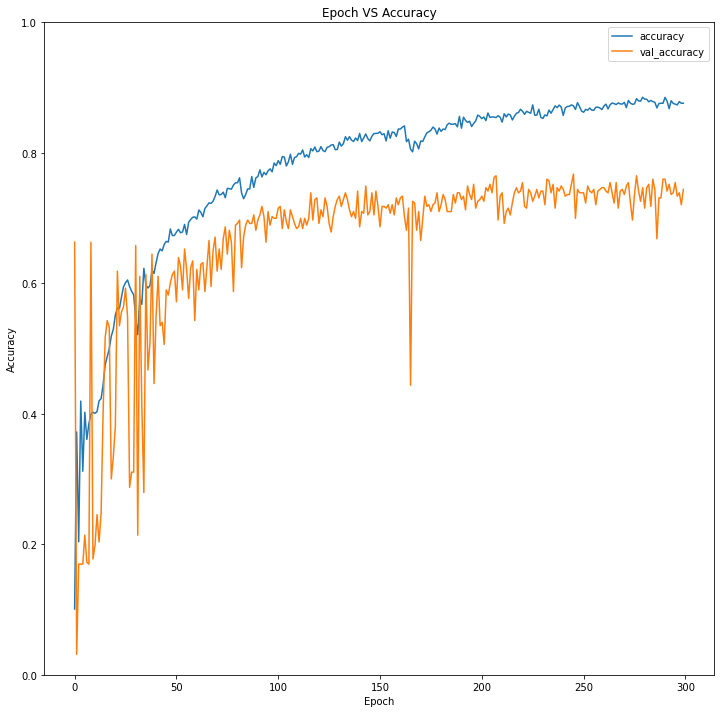

In [29]:
fig=plt.figure(figsize=(12,12))
plt.title("Epoch VS Accuracy")
plt.plot(result.history['accuracy'], label='accuracy')
plt.plot(result.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
name = "accuracy"+strftime("%Y-%m-%d_%H-%M-%S")+".png"
print(name)
plt.savefig(name)

mae2020-12-06_15-46-39.png


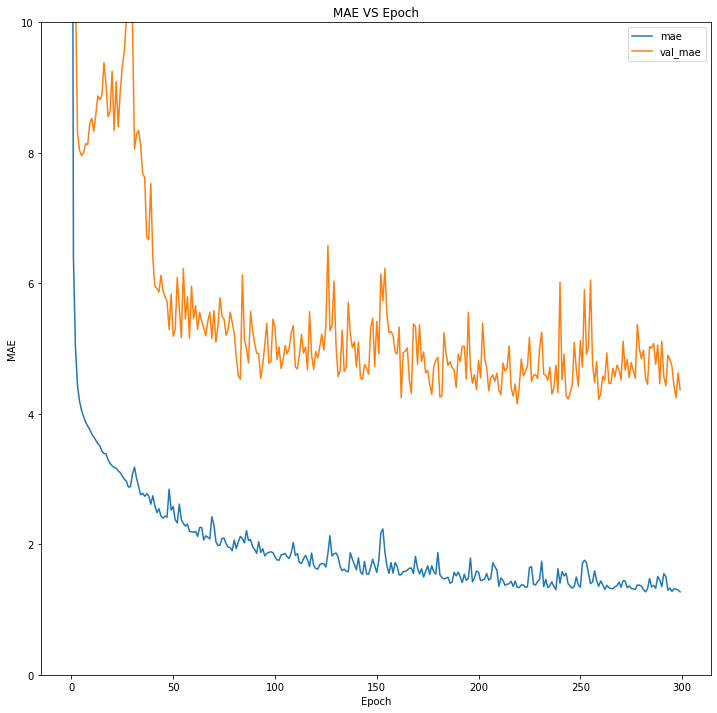

In [30]:
fig=plt.figure(figsize=(12,12))
plt.title("MAE VS Epoch")
plt.plot(result.history['mae'], label='mae')
plt.plot(result.history['val_mae'], label = 'val_mae')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.ylim([0, 10])
plt.legend()
name = "mae"+strftime("%Y-%m-%d_%H-%M-%S")+".png"
print(name)
plt.savefig(name)

## Review Model Results

In [25]:
test_loss, test_acc, acc = model.evaluate(X_train,y_train)
print("Test Accuracy = %0.2f" %test_acc)
print("Test Loss = %0.2f" %test_loss)
print("Accuracy = %0.2f" %acc)

7656/7656 [==============================] - 3s 346us/step
Test Accuracy = 1.03
Test Loss = 7.62
Accuracy = 0.91


## Save Model

In [26]:
model_name = "model"+strftime("%Y-%m-%d_%H-%M-%S")+".keras"
model.save(model_name)

# Make Predictions
## Read Test Data

In [27]:
images = []

test_data = pd.read_csv('test.csv') 
for idx, sample in test_data.iterrows():
    image = np.array(sample['Image'].split(' '), dtype=int)
    image = np.reshape(image, (96,96,1))
    images.append(image)
X_predict = np.array(images)

## Predict

In [28]:
Id_data = pd.read_csv('IdLookupTable.csv') 

test_preds = model.predict(X_predict)
test_preds[test_preds > 96] = 96

image_id = list(Id_data["ImageId"]-1)
mark_names = list(Id_data['FeatureName'])
mark_id = [mark_names.index(x) for x in mark_names]

req_predictions = [test_preds[x,y] for x,y in zip(image_id,mark_id)]

rowid = pd.Series(Id_data['RowId'], name = 'RowId')
loc = pd.Series(req_predictions, name = 'Location')
submission = pd.concat([rowid, loc], axis = 1)

sub_name = "submission"+strftime("%Y-%m-%d_%H-%M-%S")+".csv"
print(sub_name)
submission.to_csv(sub_name,index = False)

submission2020-12-06_15-46-35.csv
